In [2]:
import numpy as np
import pandas as pd
import catboost as cb
import category_encoders as ce

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, balanced_accuracy_score, roc_auc_score,
                             roc_curve, auc, log_loss)
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import seaborn as sns

import matplotlib.pyplot as plt

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def train_catboost_model(X_train, y_train, X_test, y_test, cat_features=None,
                         iterations=1000, depth=9, learning_rate=0.005, l2_leaf_reg=0.01,
                         task_type="CPU", verbose=0):
    """
    Обучает модель CatBoost для данного таргета и возвращает её.

    Параметры:
      X_train: DataFrame или array-like, обучающие признаки.
      y_train: Series или array-like, целевая переменная.
      cat_features: список названий категориальных признаков.
      iterations, depth, learning_rate, task_type, verbose: параметры CatBoost.

    Возвращает:
      Обученную модель CatBoostClassifier.
    """
    if cat_features:
        model = cb.CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            loss_function='Logloss',
            cat_features=cat_features,
            task_type=task_type,
            verbose=verbose
        )
    else:
        model = cb.CatBoostClassifier(
            iterations=iterations,
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            loss_function='Logloss',
            task_type=task_type,
            verbose=verbose
        )
    model.fit(X_train, y_train, eval_set=(X_test, y_test))
    return model

Загрузим данные

In [7]:
train_mortgage = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/train_Mortgage.csv')
val_mortgage = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/val_Mortgage.csv')

train_pension = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/train_Pension.csv')
val_pension = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/val_Pension.csv')

train_savings = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/train_Savings.csv')
val_savings = pd.read_csv('/Users/veronika/customers-propensity/Data/splited-data/val_Savings.csv')

train_data = [train_mortgage, train_pension, train_savings]
val_data = [val_mortgage, val_pension, val_savings]

Функции

In [68]:
def split_for_calibration(X_val, y_val, test_size=0.5, random_state=42):
    return train_test_split(X_val, y_val, test_size=test_size, random_state=random_state, stratify=y_val)

def draw_calibration_curves(model_sets, y_test, X_test, title_prefix):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    methods = ['До калибровки', 'Platt Scaling', 'Isotonic']
    for ax, (method, models) in zip(axs, model_sets.items()):
        for name, model in models.items():
            y_pred = model.predict_proba(X_test)[:, 1]
            frac_pos, mean_pred = calibration_curve(y_test, y_pred, n_bins=10, strategy='quantile')
            auc = roc_auc_score(y_test, y_pred)
            ll = log_loss(y_test, y_pred)
            ax.plot(mean_pred, frac_pos, label=f'{name} (AUC={auc:.3f}, LogLoss={ll:.3f})')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_title(f'{title_prefix}: {method}')
        ax.set_xlabel('Среднее предсказание вероятности')
        ax.set_ylabel('Доля положительных классов')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

def draw_probs_hist(model_sets, X_test):
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    methods = ['До калибровки', 'Platt Scaling', 'Isotonic']
    for ax, (method, models) in zip(axs, model_sets.items()):
        for name, model in models.items():
            probs = model.predict_proba(X_test)[:, 1]
            weights = np.ones_like(probs) / len(probs)
            data = {'probs': probs, 'weights': weights}
            sns.histplot(data=data, x='probs', weights='weights',
                        bins=10, binrange=(0, 1),
                        ax=ax, label=name, stat='density',
                        element='bars', edgecolor='gray', alpha=0.3)

        ax.set_title(f'{method}')
        ax.set_xlabel('Предсказанная вероятность')
        ax.set_title(f'{method}')
        ax.set_xlabel('Предсказанная вероятность')
        ax.set_ylabel('Плотность')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.show()

In [66]:
def build_model_sets(models, X_calib, y_calib):
    model_sets = {
        'До калибровки': models.copy(),
        'Platt Scaling': {},
        'Isotonic': {}
    }

    for name_, model in models.items():
        calibrator_sigmoid = CalibratedClassifierCV(estimator=model, method='sigmoid', cv='prefit')
        calibrator_sigmoid.fit(X_calib, y_calib)
        model_sets['Platt Scaling'][name_] = calibrator_sigmoid

        calibrator_isotonic = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
        calibrator_isotonic.fit(X_calib, y_calib)
        model_sets['Isotonic'][name_] = calibrator_isotonic

    return model_sets

def compute_metrics(model_sets, X_test, y_test):
    rows = []
    for method, models in model_sets.items():
        for name, model in models.items():
            probs = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, probs)
            logloss = log_loss(y_test, probs)
            rows.append({'Модель': name, 'Метод': method, 'AUC': auc, 'LogLoss': logloss})
    return pd.DataFrame(rows)

def plot_metrics_table(metrics_df):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.barplot(data=metrics_df, x='Модель', y='AUC', hue='Метод', ax=axs[0])
    axs[0].set_title('AUC по моделям и методам калибровки')
    axs[0].set_ylim(0.5, 1)
    axs[0].grid(True)

    sns.barplot(data=metrics_df, x='Модель', y='LogLoss', hue='Метод', ax=axs[1])
    axs[1].set_title('LogLoss по моделям и методам калибровки')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

def run_pipeline():
    for train_df, val_df, name in zip(train_data, val_data, ['Mortgage', 'Pension', 'Savings']):
        print(f"====== {name} ======")

        X_train = train_df.drop(columns=[name])
        y_train = train_df[name]
        X_val = val_df.drop(columns=[name])
        y_val = val_df[name]

        X_calib, X_test, y_calib, y_test = split_for_calibration(X_val, y_val)

        models = {
            'CatBoost': cb.CatBoostClassifier(iterations=1000, depth=9, learning_rate=0.005, l2_leaf_reg=0.01, verbose=0),
            'LightGBM': LGBMClassifier(n_estimators=1500, max_depth=10, learning_rate=0.005, reg_lambda=0.01),
            'ExtraTrees': ExtraTreesClassifier(n_estimators=200, max_depth=10, min_samples_split=2, min_samples_leaf=5)
        }

        for model in models.values():
            model.fit(X_train, y_train)

        model_sets = build_model_sets(models, X_calib, y_calib)

        draw_calibration_curves(model_sets, y_test, X_test, title_prefix=name)
        draw_probs_hist(model_sets, X_test)

        metrics_df = compute_metrics(model_sets, X_test, y_test)
        print(metrics_df)
        plot_metrics_table(metrics_df)

Результаты калибровки

====== Mortgage ======


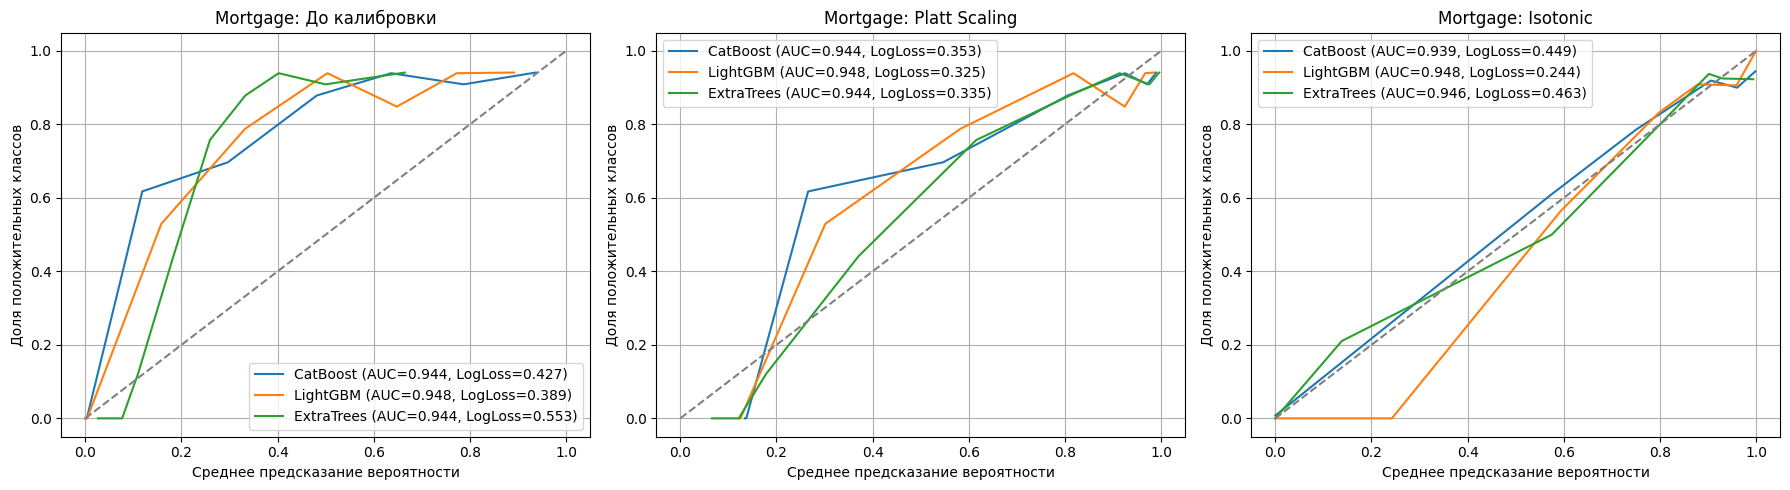

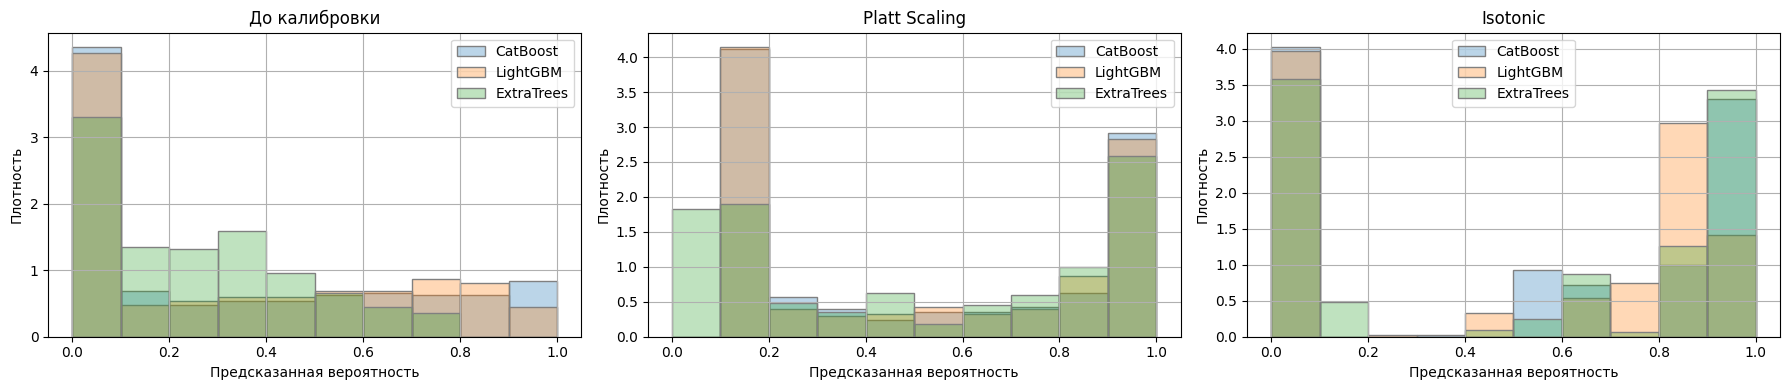

       Модель          Метод       AUC   LogLoss
0    CatBoost  До калибровки  0.943980  0.427127
1    LightGBM  До калибровки  0.947984  0.388715
2  ExtraTrees  До калибровки  0.944304  0.552560
3    CatBoost  Platt Scaling  0.943980  0.353117
4    LightGBM  Platt Scaling  0.947984  0.325142
5  ExtraTrees  Platt Scaling  0.944304  0.335317
6    CatBoost       Isotonic  0.939344  0.449396
7    LightGBM       Isotonic  0.948038  0.244428
8  ExtraTrees       Isotonic  0.945639  0.463008


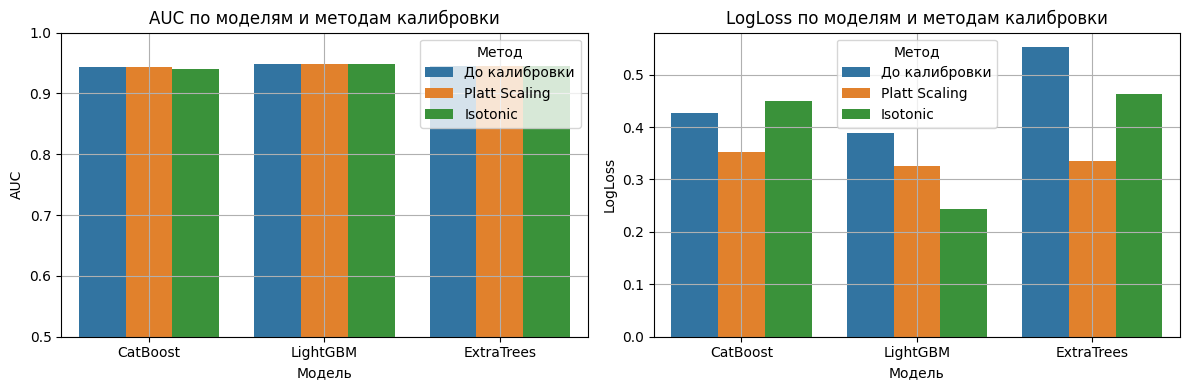

====== Pension ======


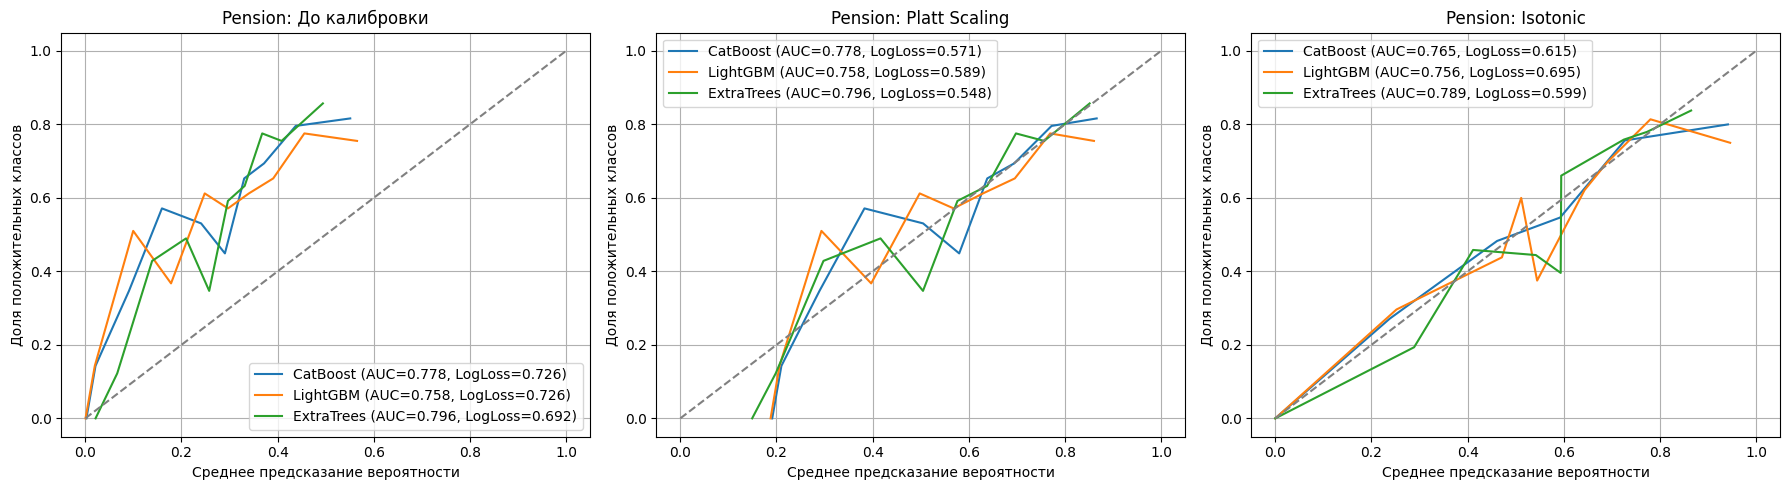

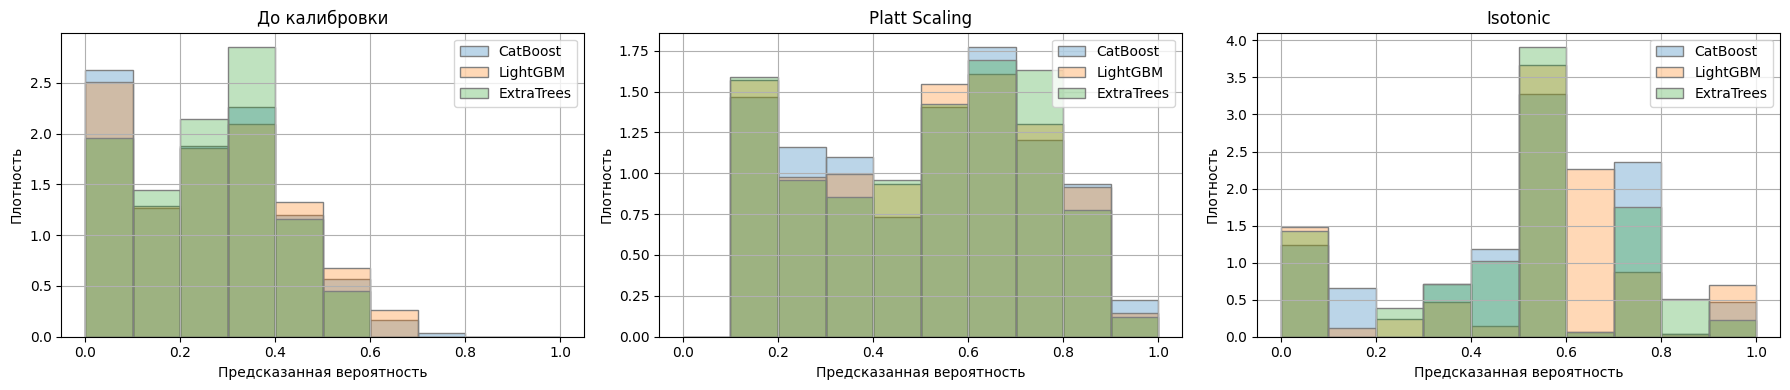

       Модель          Метод       AUC   LogLoss
0    CatBoost  До калибровки  0.778182  0.726383
1    LightGBM  До калибровки  0.757624  0.726292
2  ExtraTrees  До калибровки  0.795703  0.692285
3    CatBoost  Platt Scaling  0.778182  0.571344
4    LightGBM  Platt Scaling  0.757624  0.589025
5  ExtraTrees  Platt Scaling  0.795703  0.547805
6    CatBoost       Isotonic  0.764667  0.614714
7    LightGBM       Isotonic  0.755625  0.695300
8  ExtraTrees       Isotonic  0.788975  0.598718


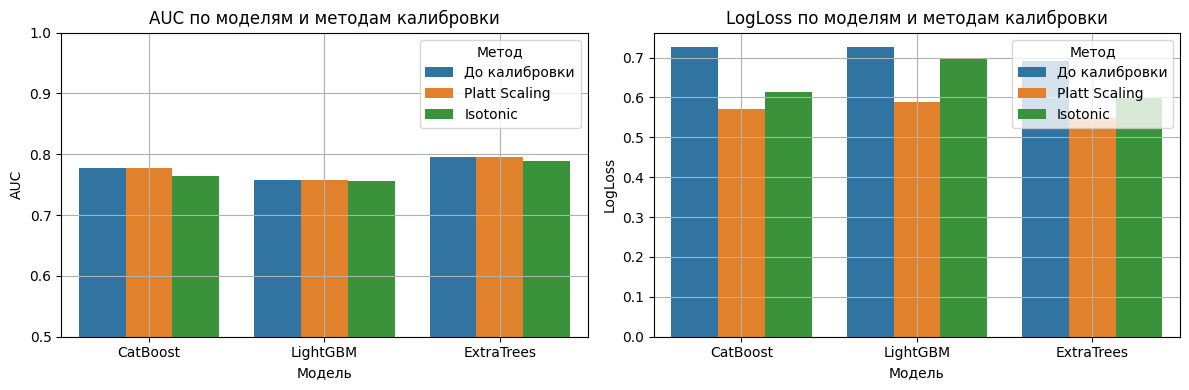

====== Savings ======


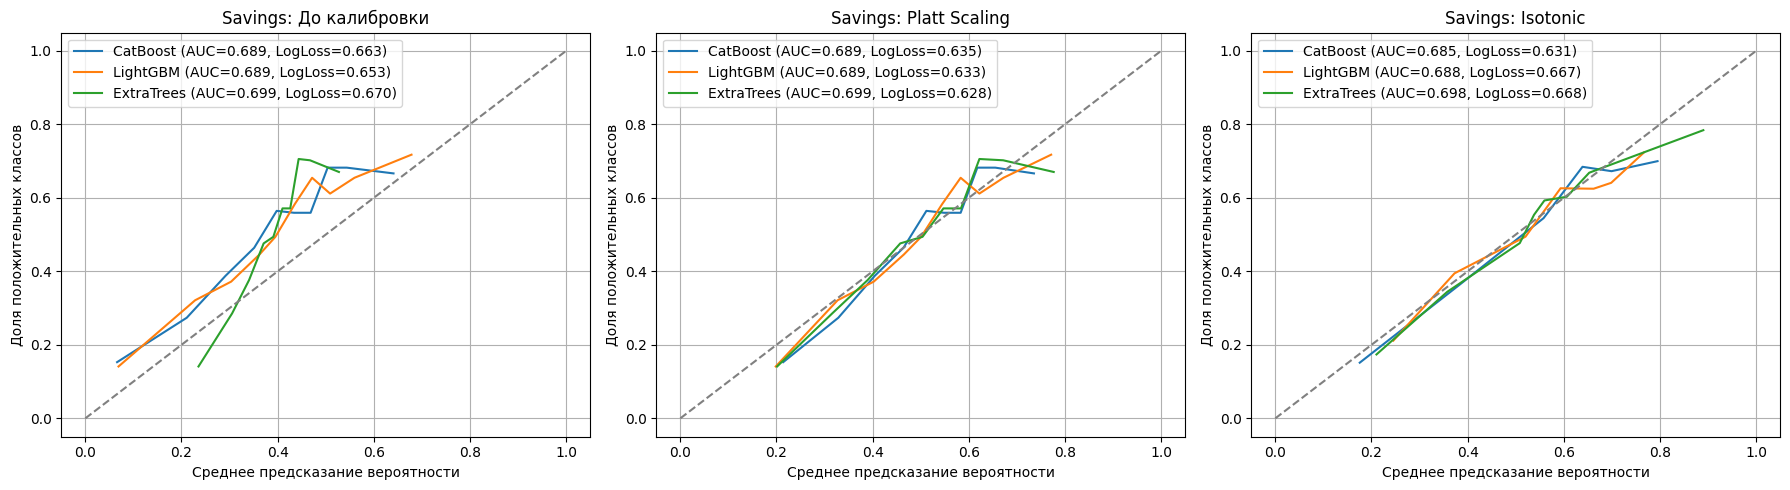

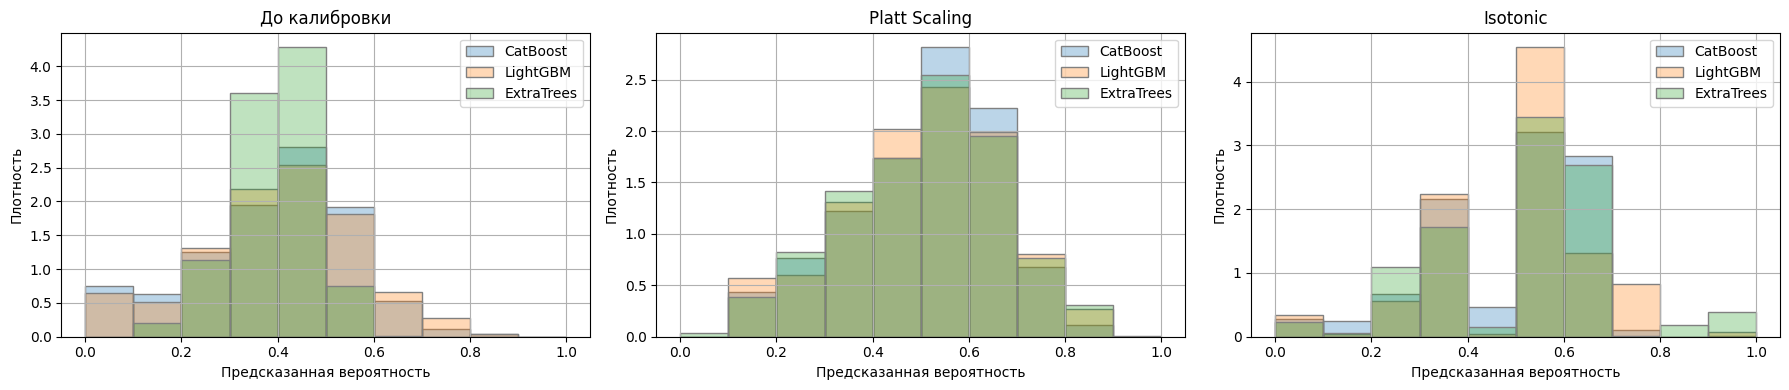

       Модель          Метод       AUC   LogLoss
0    CatBoost  До калибровки  0.689204  0.662830
1    LightGBM  До калибровки  0.689215  0.652913
2  ExtraTrees  До калибровки  0.698548  0.670305
3    CatBoost  Platt Scaling  0.689204  0.635199
4    LightGBM  Platt Scaling  0.689215  0.633343
5  ExtraTrees  Platt Scaling  0.698548  0.628303
6    CatBoost       Isotonic  0.684792  0.631064
7    LightGBM       Isotonic  0.687596  0.666613
8  ExtraTrees       Isotonic  0.698033  0.667507


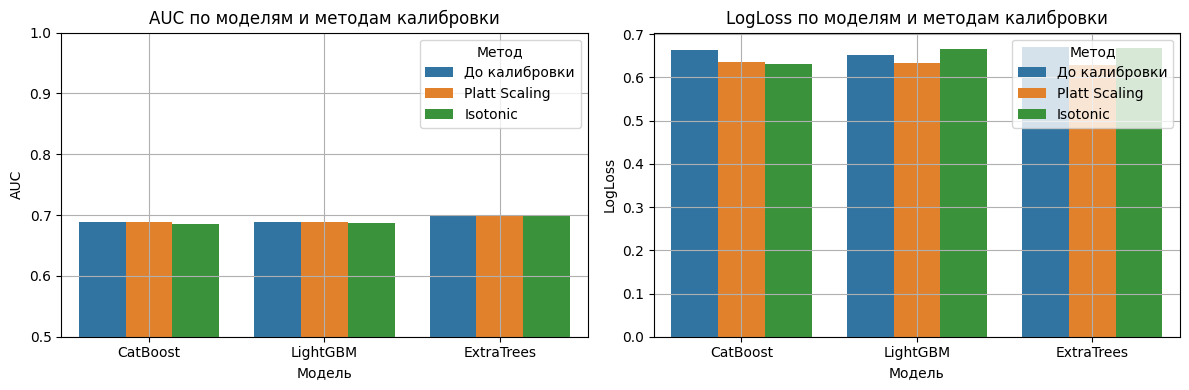

In [69]:
run_pipeline()

### **Выводы**

1. Влияние калибровки  
- AUC у всех трёх моделей на всех трёх выборках практически не меняется при Platt Scaling и Isotonic (разница < 0.01)
- LogLoss стабильно снижается после Platt Scaling (на 0.03–0.08), то есть предсказания становятся более «уверенными»
- Isotonic на данных Savings LogLoss чуть лучше, чем у Platt, но иногда наоборот (на данных Mortgage)

- Кривые калибровки:  
  - Без калибровки все модели склонны к неуверенности при крайних вероятностях (справа слева уходят от диагонали)
  - Platt Scaling почти во всех случаях сближает кривые с идеальной диагональю
  - Isotonic даёт локально лучший выравненный график, но AUC становится чуть меньше, а LogLoss чуть больше

  
2. Сравнение моделей между собой  
- Mortgage:  
  - *LightGBM* демонстрирует наивысший AUC (~0.948) и лучшее LogLoss после калибровки (0.325)
  - *CatBoost* и *ExtraTrees* близки по AUC (~0.944), но у ExtraTrees более высокий LogLoss (0.553 без калибровки)
- Pension:  
  - *ExtraTrees* чуть впереди по AUC (~0.796) и показывает наименьший LogLoss до калибровки (0.692)
  - *CatBoost* и *LightGBM* примерно одинаковы (AUC ~0.778/0.758), но у LightGBM чуть лучше LogLoss после Platt (0.589)
- Savings:  
  - AUC у всех моделей низкие и близкие (~0.689–0.699), разница несущественна
  - Лучший LogLoss даёт Platt Scaling у *ExtraTrees* (0.628), у остальных моделей разница с CatBoost/LightGBM незначительна

---
 
- Имеет смысл применять Platt Scaling: минимизируется LogLoss, кривые калибровки хорошо выравниваются 
- Для Mortgage лучше всего подходит LightGBM + Platt
- Для Pension — ExtraTrees + Platt
- Для Savings существенного преимущества нет